In [1]:
import warnings
warnings.simplefilter('ignore')

In [27]:
import pandas as pd
import numpy as np
import os
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from auton_survival.preprocessing import Preprocessor
from auton_survival import models
from sklearn.model_selection import train_test_split

In [28]:
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
for filename in sorted(os.listdir('./Data')):
    print(filename)

clients.csv
currency_rk.csv
mcc_codes.csv
report_dates.csv
sample_submit_naive.csv
train.csv
transactions.csv.zip


In [5]:
clients = pd.read_csv('./Data/clients.csv')
report_dates = pd.read_csv('./data/report_dates.csv', parse_dates=['report_dt'])
train = pd.read_csv('./Data/train.csv')
transactions = pd.read_csv('./data/transactions.csv.zip', 
                           parse_dates=['transaction_dttm'], 
                           low_memory=False, compression='zip')
transactions = transactions.sort_values('transaction_dttm').reset_index(drop=True)

In [6]:
clients = clients.merge(report_dates, on='report')

In [7]:
transactions = transactions.merge(clients[['user_id','report_dt']], on='user_id', how='left')

In [8]:
transactions['trans_positive'] = np.where( transactions['transaction_amt']>0,transactions['transaction_amt'],0)
transactions['trans_negative'] = np.where( transactions['transaction_amt']<0,transactions['transaction_amt'],0)

In [9]:
transactions = transactions.\
eval('day_diff = (report_dt - transaction_dttm).dt.days').\
groupby('user_id').agg({
    'mcc_code':["nunique"],
    'currency_rk':["nunique"],
    'day_diff':["nunique"],
    'transaction_dttm':["min","max","count"],
    'trans_positive':["sum","max","median","last"],
    'trans_negative':["sum","max","median","last"]
})
transactions.columns = [f'{x[0]}_{x[1]}' for x in transactions.columns]
transactions["count_trans_dates"]=(transactions["transaction_dttm_max"]-transactions["transaction_dttm_min"]).dt.days
transactions.head(5)

,mcc_code_nunique,currency_rk_nunique,day_diff_nunique,transaction_dttm_min,transaction_dttm_max,transaction_dttm_count,trans_positive_sum,trans_positive_max,trans_positive_median,trans_positive_last,trans_negative_sum,trans_negative_max,trans_negative_median,trans_negative_last,count_trans_dates
user_id,,,,,,,,,,,,,,,
3,4,1,8,2022-01-28 12:05:33,2022-05-14 20:39:45,11,186108.229797,104011.960938,4549.455078,104011.960938,-172401.813156,0.000000,0.000000,0.000000,106
9,22,1,54,2021-10-20 12:54:01,2022-04-19 20:02:32,90,0.000000,0.000000,0.000000,0.000000,-323434.666813,-45.579891,-840.509674,-4246.083008,181
13,4,2,18,2022-03-23 12:12:40,2022-09-07 20:48:54,22,128766.684326,70322.828125,0.000000,0.000000,-253484.063477,0.000000,-10529.004883,-16394.193359,168
37,28,1,130,2022-02-19 09:20:06,2022-08-17 09:52:33,315,10738.788574,5487.140625,0.000000,0.000000,-342598.388037,0.000000,-236.420776,-2030.448853,179
41,5,1,12,2021-11-16 15:43:21,2022-04-18 20:41:37,16,0.000000,0.000000,0.000000,0.000000,-108586.614166,-290.766998,-6328.293701,-6226.305176,153


In [10]:
clients = clients.merge(transactions.reset_index(), on='user_id', how='left')
clients.head(5)

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,mcc_code_nunique,currency_rk_nunique,day_diff_nunique,transaction_dttm_min,transaction_dttm_max,transaction_dttm_count,trans_positive_sum,trans_positive_max,trans_positive_median,trans_positive_last,trans_negative_sum,trans_negative_max,trans_negative_median,trans_negative_last,count_trans_dates
0,3,2,ОТ 101 ДО 500,0,3,2022-08-31 03:00:00,4,1,8,2022-01-28 12:05:33,2022-05-14 20:39:45,11,186108.229797,104011.960938,4549.455078,104011.960938,-172401.813156,0.0,0.000000,0.000000,106
1,90,2,ОТ 101 ДО 500,0,3,2022-08-31 03:00:00,29,1,89,2021-11-20 14:19:00,2022-05-13 12:17:28,243,8072.305969,3197.970215,0.000000,0.000000,-237427.313807,0.0,-224.017563,-18410.169922,173
2,146,2,ОТ 51 ДО 100,0,2,2022-08-31 03:00:00,40,2,167,2021-11-20 12:01:33,2022-05-21 15:22:42,637,196860.629521,27082.744141,0.000000,0.000000,-811842.683232,0.0,-302.298798,-362.948120,182
3,275,2,ОТ 101 ДО 500,0,2,2022-08-31 03:00:00,4,2,16,2021-12-10 17:53:19,2022-05-14 01:37:09,25,194745.864746,21847.828125,6714.338867,11979.168945,-50911.465088,0.0,0.000000,0.000000,154
4,572,2,NaN,0,2,2022-08-31 03:00:00,34,1,132,2021-11-20 13:16:49,2022-05-21 18:33:22,295,8927.256012,2395.687012,0.000000,0.000000,-372957.480497,0.0,-633.695618,-1214.561890,182


In [11]:
clients.columns

Index(['user_id', 'report', 'employee_count_nm', 'bankemplstatus',
       'customer_age', 'report_dt', 'mcc_code_nunique', 'currency_rk_nunique',
       'day_diff_nunique', 'transaction_dttm_min', 'transaction_dttm_max',
       'transaction_dttm_count', 'trans_positive_sum', 'trans_positive_max',
       'trans_positive_median', 'trans_positive_last', 'trans_negative_sum',
       'trans_negative_max', 'trans_negative_median', 'trans_negative_last',
       'count_trans_dates'],
      dtype='object')

In [12]:
train_columns = ['employee_count_nm', 'bankemplstatus', 'customer_age',
       'mcc_code_nunique', 'currency_rk_nunique', 'day_diff_nunique', 
       'transaction_dttm_count', 'trans_positive_sum', 'trans_positive_max',
       'trans_positive_median', 'trans_positive_last', 'trans_negative_sum',
       'trans_negative_max', 'trans_negative_median', 'trans_negative_last',
       'count_trans_dates']

cat_feats = ['employee_count_nm', 'bankemplstatus', 'customer_age']
num_feats = ['mcc_code_nunique', 'currency_rk_nunique', 'day_diff_nunique', 
       'transaction_dttm_count', 'trans_positive_sum', 'trans_positive_max',
       'trans_positive_median', 'trans_positive_last', 'trans_negative_sum',
       'trans_negative_max', 'trans_negative_median', 'trans_negative_last',
       'count_trans_dates']

In [13]:
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
dx = preprocessor.fit_transform(clients[train_columns], cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=0)

In [14]:
dx

,mcc_code_nunique,currency_rk_nunique,day_diff_nunique,transaction_dttm_count,trans_positive_sum,trans_positive_max,trans_positive_median,trans_positive_last,trans_negative_sum,trans_negative_max,trans_negative_median,trans_negative_last,count_trans_dates,employee_count_nm_БОЛЕЕ 500,employee_count_nm_ДО 10,employee_count_nm_ОТ 101 ДО 500,employee_count_nm_ОТ 11 ДО 30,employee_count_nm_ОТ 11 ДО 50,employee_count_nm_ОТ 31 ДО 50,employee_count_nm_ОТ 501 ДО 1000,employee_count_nm_ОТ 51 ДО 100,bankemplstatus_1,customer_age_1,customer_age_2,customer_age_3
0,-1.072374,-0.362362,-1.166287,-0.842608,0.371798,1.699685,1.211574,9.016779,0.158200,0.070970,0.237233,0.299158,-2.727579,0,0,1,0,0,0,0,0,0,0,0,1
1,1.241819,-0.362362,0.704493,0.718797,-0.326118,-0.452483,-0.102188,-0.168256,-0.016789,0.070970,0.195888,-1.024020,0.296052,0,0,1,0,0,0,0,0,0,0,0,1
2,2.260064,2.706605,2.505985,3.370494,0.413949,0.057407,-0.102188,-0.168256,-1.562589,0.070970,0.181440,0.273073,0.702211,0,0,0,0,0,0,0,1,0,0,1,0
3,-1.072374,2.706605,-0.981518,-0.748385,0.405658,-0.054348,1.836735,0.889595,0.485140,0.070970,0.237233,0.299158,-0.561396,0,0,1,0,0,0,0,0,0,0,1,0
4,1.704658,-0.362362,1.697623,1.068767,-0.322767,-0.469610,-0.102188,-0.168256,-0.381512,0.070970,0.120276,0.211865,0.702211,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,-0.054129,-0.362362,0.127092,-0.115747,-0.290840,-0.175991,-0.102188,-0.168256,-0.016944,0.070970,0.199690,0.261520,0.431438,0,0,0,0,0,0,0,0,0,0,1,0
95996,0.686413,-0.362362,1.050934,0.530352,-0.357762,-0.520753,-0.102188,-0.168256,-1.060782,0.066053,0.179600,0.053441,0.250923,0,0,0,0,0,0,0,0,0,1,0,0
95997,0.593845,-0.362362,0.381149,-0.102287,-0.357334,-0.518422,-0.102188,-0.168256,-0.486972,0.070970,0.066228,0.257437,0.431438,0,0,0,0,0,0,0,0,0,0,1,0
95998,-0.702103,-0.362362,-0.311733,-0.479178,-0.357762,-0.520753,-0.102188,-0.168256,0.383742,0.009106,0.069970,0.150111,0.070408,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
train_columns = dx.columns

In [16]:
dx = pd.concat([clients[['user_id','report']], dx], axis=1)

In [17]:
dx = dx.merge(train, on='user_id', how='left')

In [18]:
dx

,user_id,report,mcc_code_nunique,currency_rk_nunique,day_diff_nunique,transaction_dttm_count,trans_positive_sum,trans_positive_max,trans_positive_median,trans_positive_last,trans_negative_sum,trans_negative_max,trans_negative_median,trans_negative_last,count_trans_dates,employee_count_nm_БОЛЕЕ 500,employee_count_nm_ДО 10,employee_count_nm_ОТ 101 ДО 500,employee_count_nm_ОТ 11 ДО 30,employee_count_nm_ОТ 11 ДО 50,employee_count_nm_ОТ 31 ДО 50,employee_count_nm_ОТ 501 ДО 1000,employee_count_nm_ОТ 51 ДО 100,bankemplstatus_1,customer_age_1,customer_age_2,customer_age_3,target,time
0,3,2,-1.072374,-0.362362,-1.166287,-0.842608,0.371798,1.699685,1.211574,9.016779,0.158200,0.070970,0.237233,0.299158,-2.727579,0,0,1,0,0,0,0,0,0,0,0,1,0.0,77.0
1,90,2,1.241819,-0.362362,0.704493,0.718797,-0.326118,-0.452483,-0.102188,-0.168256,-0.016789,0.070970,0.195888,-1.024020,0.296052,0,0,1,0,0,0,0,0,0,0,0,1,0.0,91.0
2,146,2,2.260064,2.706605,2.505985,3.370494,0.413949,0.057407,-0.102188,-0.168256,-1.562589,0.070970,0.181440,0.273073,0.702211,0,0,0,0,0,0,0,1,0,0,1,0,0.0,91.0
3,275,2,-1.072374,2.706605,-0.981518,-0.748385,0.405658,-0.054348,1.836735,0.889595,0.485140,0.070970,0.237233,0.299158,-0.561396,0,0,1,0,0,0,0,0,0,0,1,0,0.0,82.0
4,572,2,1.704658,-0.362362,1.697623,1.068767,-0.322767,-0.469610,-0.102188,-0.168256,-0.381512,0.070970,0.120276,0.211865,0.702211,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,549144,7,-0.054129,-0.362362,0.127092,-0.115747,-0.290840,-0.175991,-0.102188,-0.168256,-0.016944,0.070970,0.199690,0.261520,0.431438,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN
95996,549160,7,0.686413,-0.362362,1.050934,0.530352,-0.357762,-0.520753,-0.102188,-0.168256,-1.060782,0.066053,0.179600,0.053441,0.250923,0,0,0,0,0,0,0,0,0,1,0,0,0.0,88.0
95997,549328,7,0.593845,-0.362362,0.381149,-0.102287,-0.357334,-0.518422,-0.102188,-0.168256,-0.486972,0.070970,0.066228,0.257437,0.431438,0,0,0,0,0,0,0,0,0,0,1,0,0.0,82.0
95998,549486,7,-0.702103,-0.362362,-0.311733,-0.479178,-0.357762,-0.520753,-0.102188,-0.168256,0.383742,0.009106,0.069970,0.150111,0.070408,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN


In [19]:
dx['time'] = dx['time'].fillna(-1)
dx['time'] = dx['time'].astype(np.int32)
dx['target'] = dx['target'].fillna(-1)
dx['target'] = dx['target'].astype(np.int8)

In [20]:
X = dx[dx['time']!=-1].copy()
y = dx[dx['time']!=-1][['target', 'time']].copy()

In [21]:
x_tr, x_te, y_tr, y_te = train_test_split(X[train_columns], y, test_size=0.2, random_state=333, stratify=X['report'])

In [22]:
model = models.cph.DeepCoxPH(layers=[800], random_seed=333)
model.fit(x_tr, y_tr.time, y_tr.target, vsize=0.2, val_data=None, iters=6, learning_rate=0.0001, batch_size=20, optimizer='RMSProp')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


In [23]:
predictions = model.predict_survival(x_tr, t=[60])

In [24]:
concordance_index(y_tr.time, np.array(predictions), y_tr.target)

0.7316785880707252

In [25]:
predictions = model.predict_survival(x_te, t=[60])

In [26]:
concordance_index(y_te.time, np.array(predictions), y_te.target)

0.7223395611898517

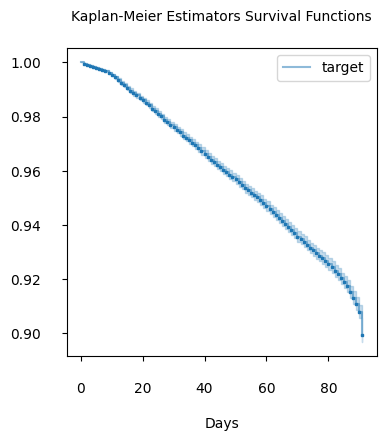

In [40]:
fig = plt.figure(figsize=(4, 4))

kmf = KaplanMeierFitter()
kmf.fit(y['time'], y['target'])
kmf.plot(label='target', alpha=0.5, show_censors=True, censor_styles={'ms': 2, 'marker': 's'})
    
plt.xlabel('Days', size=10, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=10, pad=15)
plt.tick_params(axis='y', labelsize=10, pad=15)
plt.legend(prop={'size': 10})
plt.title('Kaplan-Meier Estimators Survival Functions', size=10, pad=20)

plt.show()